# TSFS12 Hand-in Exercise 2: Planning for Vehicles with Differential Motion Constraints --- Motion Planning Using a State Lattice

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Assumes that you have all your planners in the file planners.py
from planners import breadth_first, depth_first, dijkstra, astar, best_first
from world import BoxWorld
from motionprimitives import MotionPrimitives
import os
from seaborn import despine

In [2]:
%matplotlib inline
# Run instead if you want plots in external windows
# %matplotlib  

In [ ]:
# Run the ipython magic below to activate automated import of modules. Useful if you write code in external .py files.
# %load_ext autoreload
# %autoreload 2

# Motion Primitives

Run CasADi to pre-compute all motion primitives and save results in a pickle file for later re-use

In [3]:
file_name = 'mprims.pickle'
if os.path.exists(file_name):
    mp = MotionPrimitives(file_name)
    print(f'Read motion primitives from file {file_name}')
else:
    # Define the initial states and desired goal states for the motion
    # primitives
    theta_init = np.array([0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi, 
                           -3 * np.pi / 4, -np.pi / 2, -np.pi / 4])

    x_vec = np.array([3, 2, 3, 3, 3, 1, 3, 3, 3, 2, 3])
    y_vec = np.array([2, 2, 2, 1, 1, 0, -1, -1, -2, -2, -2])
    th_vec = np.array([0, np.pi / 4, np.pi / 2, 0, np.pi / 4, 0, -np.pi / 4, 
                       0, -np.pi / 2, -np.pi / 4, 0])
    state_0 = np.column_stack((x_vec, y_vec, th_vec))

    # Vehicle parameters and constraints
    L = 1.5;        # Wheel base (m)
    v = 15;         # Constant velocity (m/s)
    u_max = np.pi/4;   # Maximum steering angle (rad)
    
    # Construct a MotionPrimitives object and generate the 
    # motion primitives using the constructed lattice and 
    # specification of the motion primitives
    mp = MotionPrimitives()
    mp.generate_primitives(theta_init, state_0, L, v, u_max)
    mp.save(file_name)

Read motion primitives from file mprims.pickle


Plot the computed motion primitives

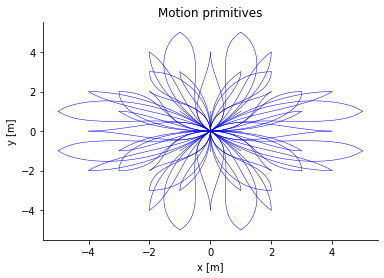

In [4]:
plt.figure(10, clear=True)
mp.plot('b', lw=0.5)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Motion primitives')
despine()

# Define Planning Mission

Create world with obstacles using the BoxWorld class

In [5]:
xx = np.arange(-2, 13)
yy = np.arange(-2, 13)
th = np.array([0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi, -3 * np.pi / 4, 
               -np.pi / 2, -np.pi / 4])

world = BoxWorld((xx, yy, th))

mission_nbr = 1

# Example planning missions

if mission_nbr == 1:
    world.add_box(0, 1, 2, 4)
    world.add_box(0, 6, 6, 4)
    world.add_box(4, 1, 6, 4)
    world.add_box(7, 7, 3, 3)

    start = [0, 0, 0]
    goal = [7, 8, np.pi / 2]
elif mission_nbr == 2:
    world.add_box(0, 1, 3, 4)
    world.add_box(0, 7, 10, 3)
    world.add_box(4, 1, 6, 4)        

    start = [0, 0, 0]
    goal = [8, 6, np.pi / 2]
elif mission_nbr == 3:
    world.add_box(-2, 0, 10, 5)
    world.add_box(-2, 6, 10, 4)

    start = [0, 5, 0]
    goal = [0, 6, np.pi]
elif mission_nbr == 4:
    world.add_box(0, 3, 10, 2)
    world.add_box(0, 5, 4, 2)
    world.add_box(6, 5, 4, 2)

    start = [5, 7, 0]
    goal = [5, 6, 0]


arrow_length = 1.
arrow_width = 0.075
start_arrow = arrow_length * np.array([np.cos(start[2]), np.sin(start[2])])
goal_arrow = arrow_length * np.array([np.cos(goal[2]), np.sin(goal[2])])

# Define the initial and goal state for the graph search by finding the
# node number (column number in world.st_sp) in the world state space

mission = {'start': {'id': np.argmin(np.sum((world.st_sp - np.array(start)[:, None])**2, axis=0))},
           'goal': {'id': np.argmin(np.sum((world.st_sp - np.array(goal)[:, None])**2, axis=0))}}

Plot world and start and goal positions

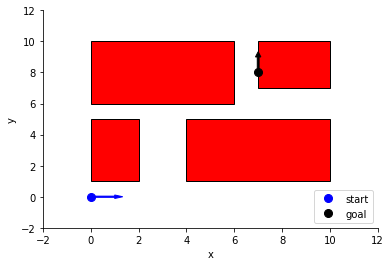

In [6]:
plt.figure(20, clear=True)
world.draw()
plt.xlabel('x')
plt.ylabel('y')
plt.plot(*start[0:2], 'bo', markersize=8, label="start")
plt.plot(*goal[0:2], 'ko', markersize=8, label="goal")
plt.arrow(*start[0:2], *start_arrow[0:2], width=arrow_width, edgecolor='b', facecolor='b' )
plt.arrow(*goal[0:2], *goal_arrow[0:2], width=arrow_width, edgecolor='k', facecolor='k' )
_ = plt.axis([world.xmin, world.xmax, world.ymin, world.ymax])
plt.legend()
despine()

# Define State-Transition Function for Lattice Planner

Define the state-transition function for the lattice planner

In [ ]:
def next_state(x, world, mp, rev=True, tol=1e-5):
    """Input arguments:
     x - current state
     world - description of the map of the world
             using the class BoxWorld
     mp - object with motion primitives of the class MotionPrimitives
     rev - Allow reversing (default: True)
     tol - tolerance for comparison of closeness of states
    
    Output arguments:
     xi - List containing the indices of N possible next states from current 
          state x, considering the obstacles and size of the world model
           
          To get the state corresponding to the first element in xi, 
          world.st_sp[:, xi[0]]
     u - List of indices indicating which motion primitive used for reaching 
         the states in xi. Each element in the list contains the two indices of the 
         motion primitives used for reaching each state and the driving direction 
         (1 forward, -1 reverse).

         If u_i = u[0] (first element), the corresponding motion primitive is
         mp.mprims[u_i[0], u_i[1]]
     d - List with the cost associated with each possible 
         transition in xi"""
    
    state_i = world.st_sp[:, x]
    theta_i = state_i[2]
    mprims = mp.mprims

    xi = []
    u = []
    d = []
    
    # Iterate through all available primitives compatible with the current 
    # angle state. Base set of motion primitives (nominally
    # corresponding to forward driving) is reversed for obtaining reverse
    # driving of the corresponding motion primitive.

    for i, j in mp.with_start_orientation_index(theta_i):
        mpi = mprims[i, j]

        # Create path to next state
        p = state_i[0:2, np.newaxis] + np.row_stack((mpi['x'], mpi['y']))
        state_next = np.row_stack((p[:, -1:], mpi["th"][-1]))
        
        # Check if the path to next state is in the allowed area
        if not world.in_bound(state_next) or not world.obstacle_free(p):
            continue
        else:
            next_idx = np.argmin(np.sum((world.st_sp - state_next)**2, axis=0))                
            xi.append(next_idx)
            d.append(mpi['ds'])
            u.append([i, j, 1])
    if rev: # With reverse driving
        for i, j in mp.with_end_orientation_index(theta_i):
            mpi = mprims[i, j]

            # Create path to next state
            p = state_i[0:2, np.newaxis] + np.row_stack((np.flip(mpi["x"]) - mpi["x"][-1], 
                                                        np.flip(mpi["y"]) - mpi["y"][-1]))
            state_next = np.row_stack((p[:, -1:], mpi["th"][0]))

            # Check if the path to next state is in the allowed area
            if not world.in_bound(state_next) or not world.obstacle_free(p):
                continue
            else:
                next_idx = np.argmin(np.sum((world.st_sp - state_next)**2, axis=0))                
                xi.append(next_idx)
                d.append(mpi['ds'])
                u.append([i, j, -1])

    return (xi, u, d)

The state-transition function is fully implemented. Apply it to the initial state and interpret the result.

In [ ]:
next_state(mission["start"]["id"], world, mp)

and do not allow reversing

In [ ]:
next_state(mission["start"]["id"], world, mp, rev=False)

# Call Planners

Get number of nodes in the state space

In [ ]:
n = world.num_nodes()

Define cost-to-go heuristic for planner

In [ ]:
cost_to_go = lambda x, xg: np.linalg.norm(world.st_sp[0:2, x] - world.st_sp[0:2, xg])

Plan using all pre-defined planners from Hand-in Exercise 1

In [ ]:
res = []
for planner in [breadth_first, depth_first, dijkstra, astar, best_first]:
    print('.', end='')    
    res.append(planner(n, mission, lambda x: next_state(x, world, mp, rev=True),
                       heuristic=cost_to_go, num_controls=3))
print('Finished!')

opt_length = [r['length'] for r in res if r['name'] == 'Dijkstra'] # Dijkstra is optimal

# Plots and Analysis

Hint: For information on a useful function

In [ ]:
?mp.plan_to_path

In [ ]:
# YOUR CODE HERE